## Trabalho Prático 3 - Exploração e Mapeamento

### Importando as bibliotecas

In [16]:
import numpy as np
import time
import random as rd
import matplotlib.pyplot as plt
from skimage.draw import line

from coppeliasim_zmqremoteapi_client import *


## Remote API functions (Python)

Criação do cliente para conexão com a api remota

Link para repositório da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python


In [17]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
Rack = sim.getObject('/rack')
print("Printando algo em cena: " + str(Rack))

Printando algo em cena: 36


### Occupancy Grid

A manipulação direta das probabilidades pode ser difícil:
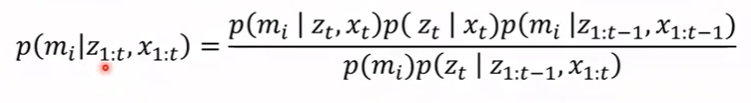

Uma forma de simplificar é usar a razão das probabilçidades. Essa também é uma maneira de assosciar os eventos (occ, free)

Evento OCC -> Ocupado:
Indica que a  célula na grade está ocupada por um obstáculo. A probabilidade de ocupação 
𝑃
(
𝑂
𝑖
∣
𝑍
)
P(O 
i
​
 ∣Z) é atualizada para refletir a presença de um obstáculo, com uma probabilidade maior de estar ocupada.

Evento free -> Livre:
Indica que uma célula na grade está livre de obstáculos. A probabilidade de ocupação 
𝑃
(
𝑂
𝑖
∣
𝑍
)
P(O 
i
​
 ∣Z) é atualizada para refletir a ausência de um obstáculo, com uma probabilidade menor de estar ocupada.

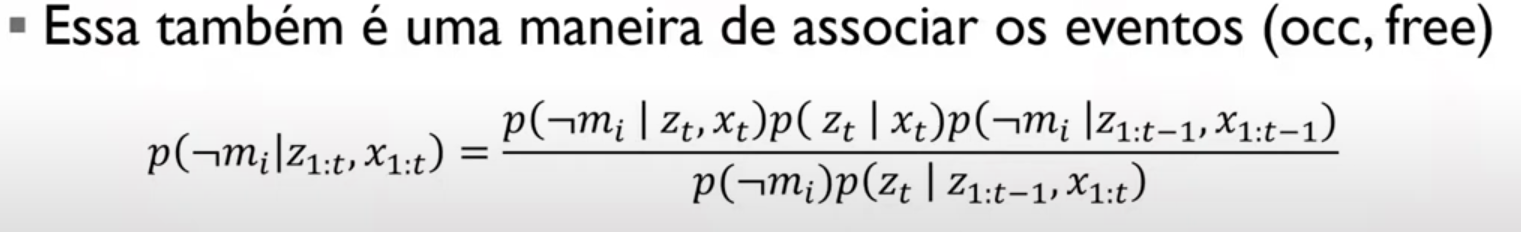

A arte-manha para simplificar o cálculo dessas probabilidades. Trabalhamos com a razão entre a probabilidade e a não probabilidade.

Com isso passamos a trabalhar com a probabilidade Odds, ou chances: (p(a) -> o(a) e vice-versa)
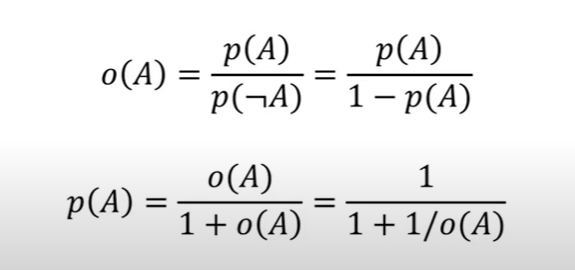

Juntando a chance com a probabilidade e manipulando um pouco as equações temos que a chance dela estar ocupada(Utiliza Zt) sendo igual a informação da nossa leitura vezes a probabilidade anterior p(occ) em t - 1, vezes toda a informação do mapa (prior).
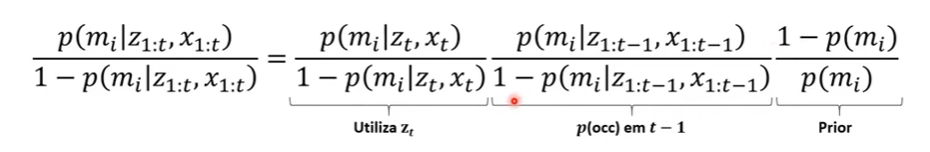

O log-odds é utilizado para evitar truncamento pela multiplicação de probabilidades. Ou seja, evita a informação perdida nos múltiplos truncamentos.
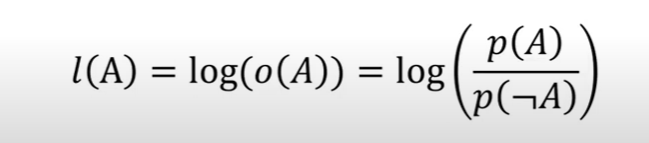

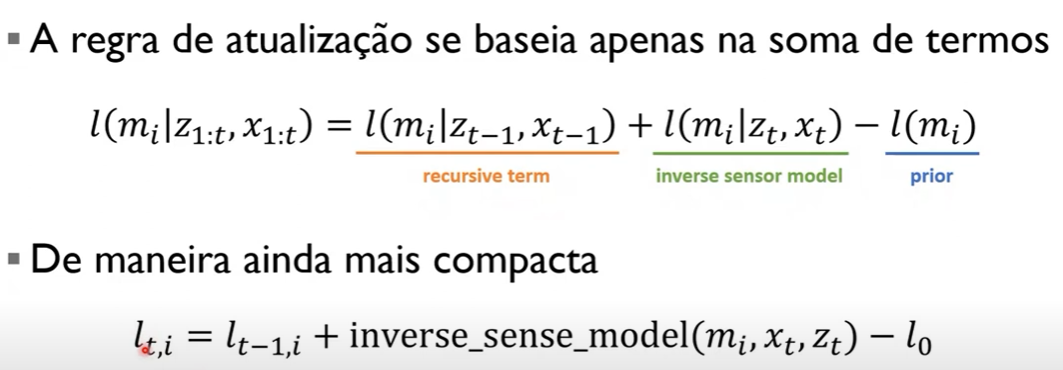

O algoritmo de mapeamento completo fica:
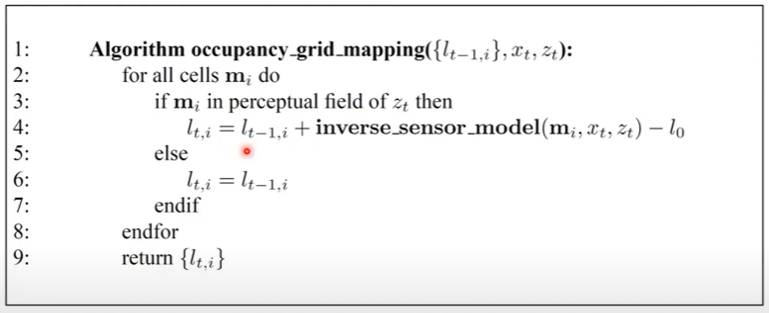

O Inverse vem para modelar ou representar como uma nova leitura acrescenta em relação ao prior. Abaixo tem oalgortimo em um sonar. 
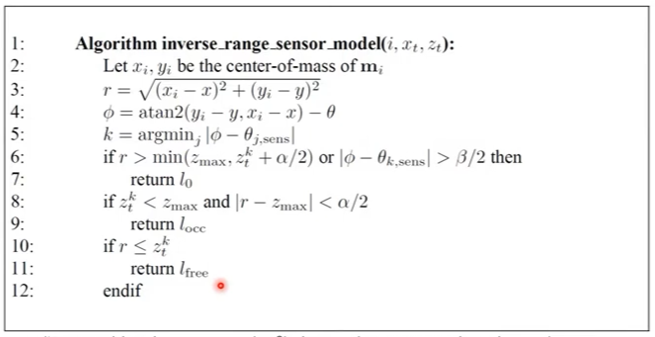

Modelo de Observação
Modela senbsores com várias leituras simultâneamente.

In [12]:
# Parâmetros do grid de ocupação
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da célula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # Número de linhas e colunas

# Inicialização do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar células desconhecidas

def log_odds(p):
    return np.log(p / (1 - p))

def inv_log_odds(l):
    return 1 - (1 / (1 + np.exp(l)))
# Atualiza a probabilidade de uma célula
def update_cell(prob, log_odds):
    return inv_log_odds(log_odds + log_odds(prob))

# Cálculo do inverse sensor model
def inverse_range_sensor_model(cel, cel_robot, max_distance, prob):
    max = max_distance/cell_size
    alpha = 0.2/cell_size
    distanceObs = np.linalg.norm(cel - cel_robot[:2])
    pocc = 0.85
    pfree = 0.1
    locc = log_odds(pocc)
    lfree = log_odds(pfree)
    if distanceObs > min(max, max_distance + alpha/2):
        return log_odds(prob)
    if max_distance < max and abs(distanceObs - max_distance) <= alpha/2:
        return locc
    if distanceObs <= max_distance:
        return lfree

def occupancy_grid_mapping2(cel_robo, cel_final, occupancy_grid):
    distanceMax = np.linalg.norm(cel_robo - cel_final)
    rr, cc = line(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
    for i in range(len(rr)):
        cel_prob = occupancy_grid[rr[i], cc[i]]
        l_ant = log_odds(cel_prob)
        cel = np.array([rr[i], cc[i]])
        l_cell = l_ant + inverse_range_sensor_model(cel, cel_robo, distanceMax, cel_prob)
        occupancy_grid[rr[i], cc[i]] = inv_log_odds(l_cell)
    return occupancy_grid

def plot_occupancy_grid(occupancy_grid, cols, rows, cell_size):
    # Função para plotar o grid de ocupação
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    ax = fig.add_subplot(111, aspect='equal')
    
    m = 1 - 1 / (1 + np.exp(occupancy_grid))
    
    plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))
    ax.set_xticks(np.arange(0, cols, cell_size))
    ax.set_yticks(np.arange(0, rows, cell_size))

    
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(ax.get_ylim()[::-1])
    
def plot_laser_points(laser_data, robot_pos, robot_ori, map_size, cell_size):
    # Função para plotar os pontos do laser
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    ax = fig.add_subplot(111, aspect='equal')
    
    Hlw = transformacaoLaser(robot_pos, robot_ori)
    
    for point in laser_data:
        point_homogeneous = np.array([point[0], point[1], 0, 1])
        point_transformed = Hlw @ point_homogeneous
        point_map = [(point_transformed[0] + map_size[0] / 2) / cell_size, 
                     (point_transformed[1] + map_size[1] / 2) / cell_size]
        
        plt.plot(point_map[0], point_map[1], 'ro')
    
    plt.xlim([0, map_size[0] / cell_size])
    plt.ylim([0, map_size[1] / cell_size])
    
    plt.show()

def transformacaoLaser(pos, ori):
    # Função para calcular a matriz de transformação homogênea do robô para o mundo
    theta = ori[2]
    transform = np.array([
        [np.cos(theta), -np.sin(theta), 0, pos[0]],
        [np.sin(theta), np.cos(theta), 0, pos[1]],
        [0, 0, 1, pos[2]],
        [0, 0, 0, 1]
    ])
    return transform
    

### Leitura dos sensores

In [13]:
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data
    else:
        return np.array([]), np.array([])

def get_all_laser_data_ruido(laser_data, trans_global):
    dados_ruidos = []
    for ang, dist in laser_data:
        if dist < 5:  # Considerando leituras válidas do laser
            x = dist * np.cos(ang) + rd.uniform(-0.05, 0.05)  # Adicionando ruído na coordenada x
            y = dist * np.sin(ang) + rd.uniform(-0.05, 0.05)  # Adicionando ruído na coordenada y
            ponto_global = trans_global @ np.array([x, y, 1])
            dados_ruidos.append([ponto_global[0], ponto_global[1]])
    return dados_ruidos
    

In [18]:
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

def transformacao(posA, oriA):
    # Criação da matriz de transformação homogênea
    RWA = Rz(oriA[2])

    TWA = np.array([[posA[0]], [posA[1]], [posA[2]]]) # Transforma a posição em um array

    # Adiciona uma linha [0, 0, 0, 1] à direita da matriz RWA
    HWA = np.column_stack((RWA, TWA))
    HWA = np.row_stack((HWA, [0, 0, 0, 1]))  # Adiciona a linha [0, 0, 0, 1] ao final da matriz HWA

    return HWA

class RobotController:
    def __init__(self, robot_name):
        self.client = RemoteAPIClient()
        self.sim = self.client.getObject('sim')
        self.robot = self.sim.getObject(f'/{robot_name}') 
        self.laser = self.sim.getObject('/fastHokuyo')
        self.robot_name = robot_name
        self.robot_handle = self.sim.getObjectHandle(f'/{robot_name}')
        self.left_wheel = self.sim.getObjectHandle(f'/{robot_name}_leftMotor')
        self.right_wheel = self.sim.getObjectHandle(f'/{robot_name}_rightMotor')
        self.goal_handle = self.sim.getObjectHandle('/ReferenceFrame')
        self.path = []  # Para armazenar o caminho do robô
        self.laser_points = []  # Para armazenar os pontos do laser

    # Função para iniciar a simulação
    def start_simulation(self):
        self.sim.startSimulation()

    # Função para parar a simulação
    def stop_simulation(self):
        self.sim.stopSimulation()

    # Função para retornar a posição do robo
    def get_robot_position(self):
        return self.sim.getObjectPosition(self.robot, -1)

    # Função para retornar a orientação do robo
    def get_robot_orientation(self):
        return self.sim.getObjectOrientation(self.robot, -1)
    
    # Função para setar a orientação do robo
    def set_robot_orientation(self, orientation):
        self.sim.setObjectOrientation(self.robot, -1, orientation)

    # Função para setar a velocidade na roda esquerda do robo
    def set_left_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.left_wheel, velocity)

    # Função para setar a velocidade na roda direita do robo
    def set_right_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.right_wheel, velocity)
        
    def get_laser_data(self):
        return readSensorData(self.sim)
    
    def set_goal_position(self, position):
        self.sim.setObjectPosition(self.goal_handle, -1, position)
        
    def update_path(self):
        robot_pos = self.get_robot_position()
        self.path.append(robot_pos)

    def update_laser_points(self, laser_data):
        for point in laser_data:
            self.laser_points.append(point)


In [15]:
def att_force(q, goal, katt = 5):
  Fatt = katt *(goal - q)
  return Fatt

def rep_force(q, obs, R=1, krep = 0.002):
    Frep = np.zeros(2)
    for obstacle in obs:
        v = q[0:2] - obstacle
        d = np.linalg.norm(v) 

        # Se a distância for menor que o raio de influência	calcular a força repulsiva
        if (d < R):  
            rep = (1/d**2)*((1/d)-(1/R))*(v/d) 
            Frep += rep

    return krep*Frep

def tt_force(q,goal,laser_data,obs,obs_pts,HWL, max_sensor_range = 5):
    Frep = np.zeros(2)
    for i in range(len(laser_data)):
        ang, dist = laser_data[i] #pega os valores de angulo e distância

        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang) #meu x
            y = dist * np.sin(ang) #meu y
            point = np.array([x,y,0,1])

            if len(HWL) != 0:
                point = HWL @ point
                obs.append(point[0:2])
                obs_pts.append(point)  
    Frep = rep_force(q, obs)
    Fatt= att_force(q, goal)
    Ft = Fatt + Frep
            
    return [Ft, Fatt, Frep]


In [21]:
def laser_to_cell(laser_data, robot_pos, robot_ori, map_size, cell_size):
    Hlw = transformacaoLaser(robot_pos, robot_ori)
    laser_data_total = []
    for point in laser_data:
        point_homogeneous = np.array([point[0], point[1], 0, 1])
        point_transformed = Hlw @ point_homogeneous
        point_map = [(point_transformed[0] + map_size[0] / 2) / cell_size, 
                     (point_transformed[1] + map_size[1] / 2) / cell_size]
        laser_data_total.append(point_map)
    return laser_data_total

# Parâmetros do grid de ocupação
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da célula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # Número de linhas e colunas

# Inicialização do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar células desconhecidas

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posição inicial do objetivo
    robot_controller.set_goal_position(goal_position)
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    
    robot_path = []
    laser_data_total = []
    
    while distance_goal > 0.5:
        # Leitura do laser
        if laser_range_data is not None and laser_angle_data is not None:
            raw_range_data, raw_angle_data = readSensorData() 
            
        laser_data = np.array([raw_angle_data, raw_range_data]).T
    
        laser_transform = Rz(np.pi / 2)
        noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)

        # Atualizando robo
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        robot_path.append(robot_pos)
        
        for i in range(len(laser_data)):# Para cada feixe do laser
            # fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
            # robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
            # max_cel = len(occupancy_grid) - 1
            # robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
            # robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
            # celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
            # celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
            point = np.append(point[:3], 1)  # Ensure point has a size of 4
            point = laser_transform @ point
            
            ang, dist = laser_data[i] # pega os valores de angulo e distância
            if (5 - dist) > 0.1:
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                point = np.array([x, y, 0, 1])
                
                if len(laser_transform) != 0:
                    point = laser_transform @ point
                    obs.append(point[0:2])
                    obs_pts.append(point)
                    occupancy_grid = occupancy_grid_mapping2(np.array([robot_pos[0], robot_pos[1]]), np.array([laser_x, laser_y]), occupancy_grid)
            
            laser_data_total.append(laser_data[i])
            
            occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
        
        Hlw = transformacao(robot_pos, robot_ori) # Matriz de transformação do laser para o mundo
        
        obs = [] # Lista de obstáculos
        obs_pts = [] # Lista de pontos dos obstáculos
        
        # Calculando forças
        Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
            
        dx, dy = Ft

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (np.arctan2(dy, dx) - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        

        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    #robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)

Program Started


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

Program Started


C:\Users\felip\AppData\Local\Temp\ipykernel_11084\372765575.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))
C:\Users\felip\AppData\Local\Temp\ipykernel_11084\372765575.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(p / (1 - p))


Program ended


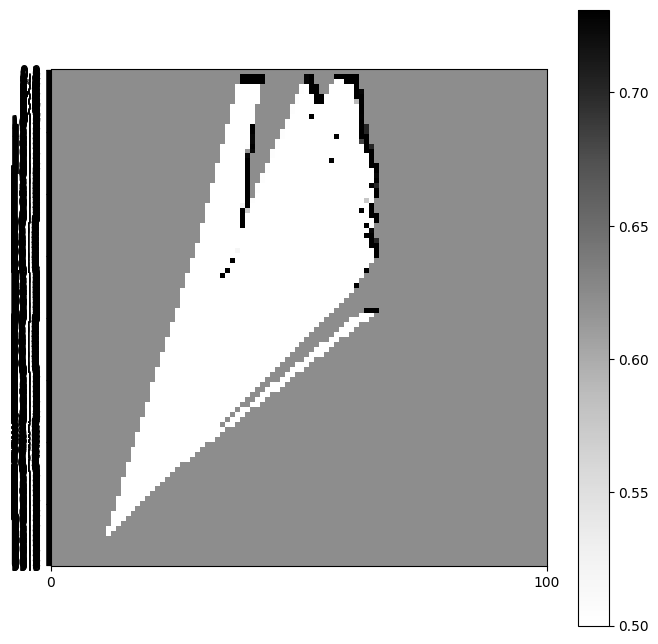

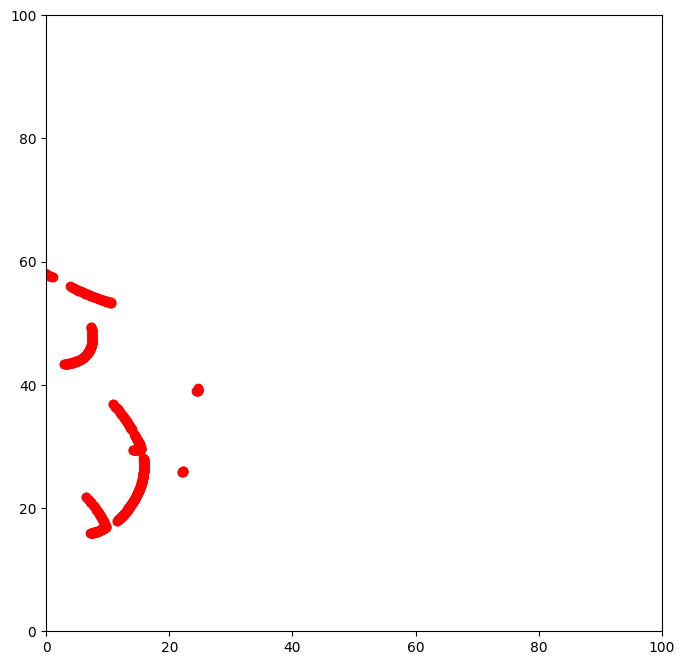

In [9]:
def laser_to_grid(robot_pos, robot_ori, laser_data, grid_size, cell_size):
    """
    Converte as leituras do laser em células do occupancy grid.

    Parameters:
    - robot_pos: Posição do robô (x, y, z)
    - robot_ori: Orientação do robô (roll, pitch, yaw)
    - laser_data: Dados do laser [(distância, ângulo), ...]
    - grid_size: Tamanho do grid (rows, cols)
    - cell_size: Tamanho da célula no grid

    Returns:
    - grid_cells: Lista de células ocupadas no grid [(row, col), ...]
    """
    grid_cells = []
    robot_x, robot_y, robot_z = robot_pos
    _, _, robot_yaw = robot_ori
    
    for distance, angle in laser_data:
        # Convertendo coordenadas polares para cartesianas
        x_laser = distance * np.cos(angle)
        y_laser = distance * np.sin(angle)

        # Rotacionando as coordenadas do laser para alinhar com a orientação do robô
        x_world = x_laser * np.cos(robot_yaw) - y_laser * np.sin(robot_yaw)
        y_world = x_laser * np.sin(robot_yaw) + y_laser * np.cos(robot_yaw)

        # Convertendo para coordenadas globais
        x_global = x_world + robot_x
        y_global = y_world + robot_y

        # Convertendo para células do grid
        cell_x = int(x_global / cell_size)
        cell_y = int(y_global / cell_size)
        
        if 0 <= cell_x < grid_size[1] and 0 <= cell_y < grid_size[0]:
            grid_cells.append((cell_y, cell_x))
    
    return grid_cells

# Função para calcular o ângulo em relação ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Função para girar o robô para a direção do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orientação correta se a diferença for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rotação suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    # guardar a trajetória do robô
    robot_path = []
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posição inicial do objetivo
    robot_controller.set_goal_position(goal_position)
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    
    # Calcula o ângulo para o objetivo e orienta o robô
    goal_angle = angle_to_goal(robot_pos, goal_position)
    orient_towards_goal(robot_controller, goal_angle)
    
    while distance_goal > 0.5:
        # Leitura do laser
        if laser_range_data is not None and laser_angle_data is not None:
            raw_range_data, raw_angle_data = readSensorData() 
            
        laser_data = np.array([raw_angle_data, raw_range_data]).T
    
        laser_transform = Rz(np.pi / 2)
        noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)
        
        laser_data_total = []
        obs = [] # Lista de obstáculos
        obs_pts = [] # Lista de pontos dos obstáculos

        # Atualizando robo
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        robot_path.append(robot_pos)
        
        # Transformar matriz de transformação do laser para o mundo
        Hlw = transformacaoLaser(robot_pos, robot_ori)  
        
        for i in range(len(laser_data)):
            ang, dist = laser_data[i] # pega os valores de angulo e distância
            if (5 - dist) > 0.1: # 5 = max_sensor_range
                x = dist * np.cos(ang)
                y = dist * np.sin(ang)
                point = np.array([x, y, 0, 1])
                
                if len(Hlw) != 0:
                    point = Hlw @ point
                    obs.append(point[0:2])
                    obs_pts.append(point)
                    
                
            fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
            robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
            max_cel = len(occupancy_grid) - 1
            robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
            robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
            celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
            celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
            
            # transformar o laser em relação ao mundo
            
            laser_data_total.append(laser_data[i])
            
            occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
        
        Hlw = transformacao(robot_pos, robot_ori) # Matriz de transformação do laser para o mundo
        

        
        # Calculando forças
        Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
            
        dx, dy = Ft

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (np.arctan2(dy, dx) - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        

        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)


In [25]:
import numpy as np
from skimage.draw import line
import time

# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def log_odds(p):
    return np.log(p / (1 - p))

def inv_log_odds(l):
    return 1 - (1 / (1 + np.exp(l)))

# Atualiza a probabilidade de uma célula
def update_cell(prob, log_odds):
    return inv_log_odds(log_odds + log_odds(prob))

# Cálculo do inverse sensor model
def inverse_range_sensor_model(cel, cel_robot, max_distance, prob):
    max_dist = max_distance / cell_size
    alpha = 0.2 / cell_size
    distanceObs = np.linalg.norm(cel - cel_robot[:2])
    pocc = 0.85
    pfree = 0.1
    locc = log_odds(pocc)
    lfree = log_odds(pfree)
    if distanceObs > min(max_dist, max_distance + alpha / 2):
        return log_odds(prob)
    if max_distance < max_dist and abs(distanceObs - max_distance) <= alpha / 2:
        return locc
    if distanceObs <= max_distance:
        return lfree

def occupancy_grid_mapping2(cel_robo, cel_final, occupancy_grid):
    distanceMax = np.linalg.norm(cel_robo - cel_final)
    rr, cc = line(cel_robo[0], cel_robo[1], cel_final[0], cel_final[1])
    for i in range(len(rr)):
        cel_prob = occupancy_grid[rr[i], cc[i]]
        l_ant = log_odds(cel_prob)
        cel = np.array([rr[i], cc[i]])
        l_cell = l_ant + inverse_range_sensor_model(cel, cel_robo, distanceMax, cel_prob)
        occupancy_grid[rr[i], cc[i]] = inv_log_odds(l_cell)
    return occupancy_grid

# Função para calcular o ângulo em relação ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Função para girar o robô para a direção do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orientação correta se a diferença for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rotação suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Função para detectar obstáculos usando os dados do laser
def detect_obstacles(laser_data, threshold=0.5):
    # Verifica se existe algum obstáculo dentro do limite de distância
    for distance in laser_data[:, 1]:
        if distance < threshold:
            return True
    return False

# Função para encontrar uma nova direção livre de obstáculos
def find_new_direction(robot_controller, laser_data, current_angle):
    num_angles = 36  # Número de ângulos a serem verificados (360/10)
    for i in range(num_angles):
        angle = current_angle + (i * np.deg2rad(10))
        angle = angle % (2 * np.pi)  # Garante que o ângulo esteja entre 0 e 2pi
        
        robot_controller.set_robot_orientation([0, 0, angle])  # Muda a orientação do robô
        # Aguarda um tempo para o robô ajustar sua orientação
        time.sleep(0.5)
        
        # Verifica os dados do laser na nova orientação
        raw_range_data, raw_angle_data = readSensorData()
        new_laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Se não houver obstáculos na nova direção, retorna o novo ângulo
        if not detect_obstacles(new_laser_data):
            return angle
    return current_angle  # Se não encontrar uma direção livre, retorna o ângulo atual

# Função para obter a posição de um objeto
def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

# Função para obter a orientação de um objeto
def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

# Função para criar a matriz de transformação homogênea
def transformacao(posA, oriA):
    RWA = Rz(oriA[2])
    TWA = np.array([[posA[0]], [posA[1]], [posA[2]]]) # Transforma a posição em um array
    HWA = np.column_stack((RWA, TWA))
    HWA = np.row_stack((HWA, [0, 0, 0, 1]))  # Adiciona a linha [0, 0, 0, 1] ao final da matriz HWA
    return HWA

class RobotController:
    def __init__(self, robot_name):
        self.client = RemoteAPIClient()
        self.sim = self.client.getObject('sim')
        self.robot = self.sim.getObject(f'/{robot_name}') 
        self.laser = self.sim.getObject('/fastHokuyo')
        self.robot_name = robot_name
        self.robot_handle = self.sim.getObjectHandle(f'/{robot_name}')
        self.left_wheel = self.sim.getObjectHandle(f'/{robot_name}_leftMotor')
        self.right_wheel = self.sim.getObjectHandle(f'/{robot_name}_rightMotor')
        self.goal_handle = self.sim.getObjectHandle('/ReferenceFrame')
        self.path = []  # Para armazenar o caminho do robô
        self.laser_points = []  # Para armazenar os pontos do laser

    # Função para iniciar a simulação
    def start_simulation(self):
        self.sim.startSimulation()

    # Função para parar a simulação
    def stop_simulation(self):
        self.sim.stopSimulation()

    # Função para retornar a posição do robo
    def get_robot_position(self):
        return self.sim.getObjectPosition(self.robot, -1)

    # Função para retornar a orientação do robo
    def get_robot_orientation(self):
        return self.sim.getObjectOrientation(self.robot, -1)
    
    # Função para setar a orientação do robo
    def set_robot_orientation(self, orientation):
        self.sim.setObjectOrientation(self.robot, -1, orientation)

    # Função para setar a velocidade na roda esquerda do robo
    def set_left_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.left_wheel, velocity)

    # Função para setar a velocidade na roda direita do robo
    def set_right_wheel_velocity(self, velocity):
        self.sim.setJointTargetVelocity(self.right_wheel, velocity)
        
    def get_laser_data(self):
        return readSensorData(self.sim)
    
    def set_goal_position(self, position):
        self.sim.setObjectPosition(self.goal_handle, -1, position)
        
    def update_path(self):
        robot_pos = self.get_robot_position()
        self.path.append(robot_pos)

    def update_laser_points(self, laser_data):
        for point in laser_data:
            self.laser_points.append(point)

# Parâmetros do grid de ocupação
map_size = [10, 10]  # Tamanho do mapa em metros
cell_size = 0.1  # Tamanho da célula em metros
rows, cols = int(map_size[0] / cell_size), int(map_size[1] / cell_size)  # Número de linhas e colunas

# Inicialização do occupancy grid
occupancy_grid = np.full((rows, cols), 0.5)  # Valor inicial 0.5 para representar células desconhecidas

# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    goal_position = [-2.4, -2.45, 0]  # Posição inicial do objetivo
    robot_controller.set_goal_position(goal_position)

    # Calcula o ângulo para o objetivo e orienta o robô
    goal_angle = angle_to_goal(robot_pos, goal_position)
    orient_towards_goal(robot_controller, goal_angle)
    
    distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
    threshold = 0.1

    laser_data_total = []

    while distance_goal > threshold:
        laser_data = robot_controller.get_laser_data()
        laser_data_total.extend(laser_data)
        
        robot_pos = robot_controller.get_robot_position()
        robot_ori = robot_controller.get_robot_orientation()
        
        # Atualiza o occupancy grid com os dados do laser
        for point in laser_data:
            x, y = point
            cell_x = int((robot_pos[0] + x) / cell_size)
            cell_y = int((robot_pos[1] + y) / cell_size)
            occupancy_grid = occupancy_grid_mapping2(np.array([cell_x, cell_y]), np.array([robot_pos[0], robot_pos[1]]), occupancy_grid)
        
        if detect_obstacles(laser_data):
            # Encontra uma nova direção livre de obstáculos
            new_direction = find_new_direction(robot_controller, laser_data, robot_ori[2])
            robot_controller.set_robot_orientation([0, 0, new_direction])
            goal_angle = new_direction

        kr = 0.05
        kt = 0.1

        v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
        w = kt * (goal_angle - robot_ori[2])

        v = max(min(v, 0.2), -0.2)
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

        vr = (2 * v + 0.23 * w) / (2 * 0.035)
        vl = (2 * v - 0.23 * w) / (2 * 0.035)
        
        # Envia velocidades calculadas
        robot_controller.set_left_wheel_velocity(0.6 * vl)
        robot_controller.set_right_wheel_velocity(0.6 * vr)

        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(laser_data_total, robot_pos, robot_ori, map_size, cell_size)


Program Started


Exception: illegal argument ("don't know how to cbor serialize object of type %s", <class 'type'>)

In [29]:
# Função para calcular o ângulo em relação ao objetivo
def angle_to_goal(robot_pos, goal_pos):
    dx = goal_pos[0] - robot_pos[0]
    dy = goal_pos[1] - robot_pos[1]
    return np.arctan2(dy, dx)

# Função para girar o robô para a direção do objetivo
def orient_towards_goal(robot_controller, goal_angle):
    while True:
        robot_ori = robot_controller.get_robot_orientation()
        current_angle = robot_ori[2]
        angle_diff = goal_angle - current_angle
        
        if abs(angle_diff) < np.deg2rad(5):  # Considera a orientação correta se a diferença for menor que 5 graus
            break

        w = 0.1 * angle_diff  # Proporcional ao erro angular
        
        # Limita a velocidade angular para garantir uma rotação suave
        w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))
        
        vr = 0.23 * w / (2 * 0.035)
        vl = -0.23 * w / (2 * 0.035)

        robot_controller.set_left_wheel_velocity(vl)
        robot_controller.set_right_wheel_velocity(vr)

# Função para detectar obstáculos usando os dados do laser
def detect_obstacles(laser_data, threshold=0.5):
    # Verifica se existe algum obstáculo dentro do limite de distância
    for distance in laser_data[:, 1]:
        if distance < threshold:
            return True
    return False

# Função para encontrar uma nova direção livre de obstáculos
def find_new_direction(robot_controller, laser_data, current_angle):
    num_angles = 36  # Número de ângulos a serem verificados (360/10)
    for i in range(num_angles):
        angle = current_angle + (i * np.deg2rad(10))
        angle = angle % (2 * np.pi)  # Garante que o ângulo esteja entre 0 e 2pi
        
        robot_controller.set_robot_orientation(angle)  # Muda a orientação do robô
        # Aguarda um tempo para o robô ajustar sua orientação
        time.sleep(0.5)
        
        # Verifica os dados do laser na nova orientação
        raw_range_data, raw_angle_data = readSensorData()
        new_laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Se não houver obstáculos na nova direção, retorna o novo ângulo
        if not detect_obstacles(new_laser_data):
            return angle
    return current_angle  # Se não encontrar uma direção livre, retorna o ângulo atual


# Conectando-se ao CoppeliaSim
clientID = sim.startSimulation()

if clientID != -1:
    print('Program Started')
    
    robot_controller = RobotController('kobuki')

    robot_controller.start_simulation()
    robot_pos = robot_controller.get_robot_position()
    robot_ori = robot_controller.get_robot_orientation()

    # Lista de objetivos que cobre todo o mapa
    goal_positions = [[0.4, -4.45, 1], [0.8, -1.8, 1], [1.3, 0, 1], [0.7, 3, 1], [2.5, 4.3, 1]] #  
    
    for goal_position in goal_positions:
        robot_controller.set_goal_position(goal_position)
        
        distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))
        
        # Calcula o ângulo para o objetivo e orienta o robô
        goal_angle = angle_to_goal(robot_pos, goal_position)
        orient_towards_goal(robot_controller, goal_angle)
        
        while distance_goal > 0.5:
            # Leitura do laser
            if laser_range_data is not None and laser_angle_data is not None:
                raw_range_data, raw_angle_data = readSensorData() 
                
            laser_data = np.array([raw_angle_data, raw_range_data]).T
        
            laser_transform = Rz(np.pi / 2)
            noisy_data = get_all_laser_data_ruido(laser_data, laser_transform)
            
            laser_data_total = []

            # Atualizando robo
            robot_pos = robot_controller.get_robot_position()
            robot_ori = robot_controller.get_robot_orientation()
            
            # Verifica a presença de obstáculos e ajusta a direção se necessário
            if detect_obstacles(laser_data):
                new_angle = find_new_direction(robot_controller, laser_data, np.rad2deg(robot_ori[2]))
                orient_towards_goal(robot_controller, new_angle)

            
            for i in range(len(laser_data)):
                fim_laser = Rz(np.pi/2) @ [(np.array(laser_data[i][0]) + map_size[0]/2), (np.array(laser_data[i][1]) + map_size[1]/2), 0]
                robo_mapa = Rz(np.pi/2) @ [(robot_pos[0] + map_size[0]/2), (robot_pos[1] + map_size[1]/2), 0]
                max_cel = len(occupancy_grid) - 1
                robot_x = min(max_cel, (robo_mapa[0]/cell_size).astype(int)) # posicao x do robo na celula do mapa occ grid
                robot_y = min(max_cel, (robo_mapa[1]/cell_size).astype(int)) # posicao y do robo na celula do mapa occ grid
                celula_x = min(max_cel, (fim_laser[0]/cell_size).astype(int)) # posicao x do laser na celula do mapa occ grid
                celula_y = min(max_cel, (fim_laser[1]/cell_size).astype(int))
                
                laser_data_total.append(laser_data[i])
                #occupancy_grid = occupancy_grid_mapping3(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid, cell_size)
                occupancy_grid = occupancy_grid_mapping2(np.array([robot_x, robot_y]), np.array([celula_x, celula_y]), occupancy_grid)
            
            Hlw = transformacao(robot_pos, robot_ori) # Matriz de transformação do laser para o mundo
            
            obs = [] # Lista de obstáculos
            obs_pts = [] # Lista de pontos dos obstáculos
            
            # Calculando forças
            Ft, Fatt, Frep = tt_force(np.array(robot_pos[:2]), np.array(goal_position[:2]), laser_data, obs, obs_pts, Hlw)
                
            dx, dy = Ft

            kr = 0.05
            kt = 0.1
            
            #L = 0.381 # Distância entre as rodas
            #R = 0.0975 # Raio da roda
            L = 0.23
            R = 0.035

            v = kr * (dx * np.cos(robot_ori[2]) + dy * np.sin(robot_ori[2]))
            w = kt * (np.arctan2(dy, dx) - robot_ori[2])

            v = max(min(v, 0.2), -0.2)
            w = max(min(w, np.deg2rad(45)), -np.deg2rad(45))

            # Cinemática inversa
            vr = (2 * v + 0.23 * w) / (2 * 0.035)
            vl = (2 * v - 0.23 * w) / (2 * 0.035)
            #vr = (2 * v + L * w) / (2 * R)
            #vl = (2 * v - L * w) / (2 * R)

            # Envia velocidades calculadas
            robot_controller.set_left_wheel_velocity(0.5*vl)
            robot_controller.set_right_wheel_velocity(0.5*vr)

            distance_goal = np.linalg.norm(np.array(goal_position[:2]) - np.array(robot_pos[:2]))

        print(f'Goal {goal_position} reached.')

    robot_controller.set_left_wheel_velocity(0)
    robot_controller.set_right_wheel_velocity(0)
    #robot_controller.stop_simulation()
    print('Program ended')
    
    plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
    plot_laser_points(noisy_data, robot_pos, robot_ori, map_size, cell_size)


Program Started


C:\Users\felip\AppData\Local\Temp\ipykernel_16180\4010686988.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))
C:\Users\felip\AppData\Local\Temp\ipykernel_16180\4010686988.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(p / (1 - p))


Exception: 316: in sim.setObjectOrientation: one of the function's argument type is not correct.

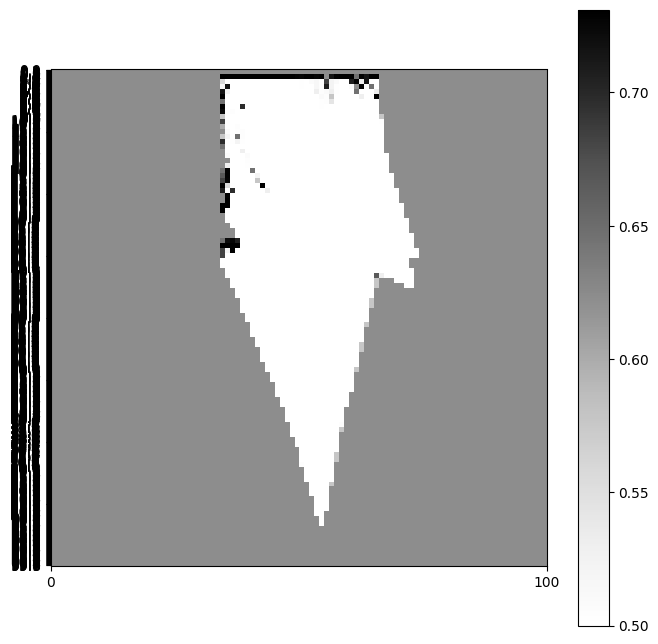

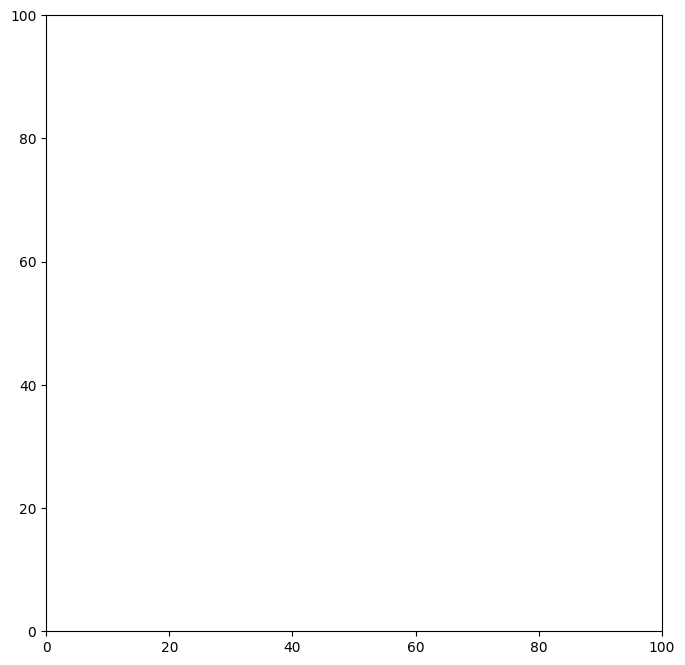

In [124]:
#plot_occupancy_grid(occ_grid)
plot_occupancy_grid(occupancy_grid, cols, rows, cell_size)
plot_laser_points(robot_controller.laser_points, robot_pos, robot_ori, map_size, cell_size)